In [146]:
#Importamos las librerias que necesitaremos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors             import KNeighborsClassifier # Modelo de K Vecinos Cercanos
from sklearn.metrics               import accuracy_score     # Función para calcular la precisión de clasificación
from sklearn.metrics               import confusion_matrix   # Función para calcular una matriz de confusión
from scipy.spatial.distance        import cdist    
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics         import accuracy_score, confusion_matrix
##### Objetivo: Construir un clasificador para el data set
#               disponible en http://mlr.cs.umass.edu/ml/datasets/Car+Evaluation
#               comparando los modelos Random Forest y KNN.
#Autor:_________Salvador Bárcenas Valladolid

In [212]:
#Importamos el dataset
car=pd.read_csv("car.csv")
car.head(2)

,buying,maint,doors,person,lug_boot,safety,Clase
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc


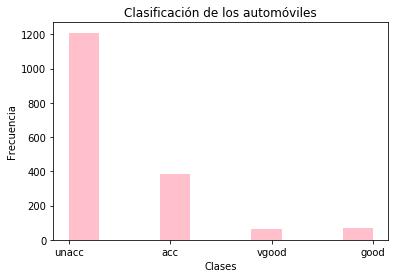

In [219]:
#Vamos a explorar el dataset con histogramas para ver que tan balanceado está con respecto
#a las clasesplt.figure(figsize=(6,6))
plt.hist(car["Clase"], color="pink", )
plt.title("Clasificación de los automóviles")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

In [126]:
car.columns=['buying', 'maint', 'doors', 'person', 'lug_boot', 'safety',
       'Clase']
columnas_categoricas=['buying', 'maint', 'lug_boot',"person", 'safety',
       'Clase']
car["doors"]=np.where(car["doors"]=="5more",5,car["doors"])
car["doors"]=pd.to_numeric(car["doors"])

In [127]:
#Vamos a transformar las columnas a enteros para que
#los modelos de sklearn no tengan conflicto.
for i in columnas_categoricas:
    car[i]=pd.Categorical(car[i])
    car[i]=car[i].cat.codes
       

In [128]:
#Observamos como queda:
car.head(2)

,buying,maint,doors,person,lug_boot,safety,Clase
0,3,3,2,0,2,1,2
1,3,3,2,0,2,2,2


In [196]:
#Particionamos el dataset en entrenamieento y prueba.
matriz_diseño =car.values[:, 0:6]
y_reales      = car.values[:,6]
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(matriz_diseño, y_reales, test_size = 0.3, random_state = 0)
#Esta función tiene más parámetros que podemos
#modificar, sin embargo sólo fijemos el la p para ser usada cómo 
#distancia entre puntos por el algoritmo con respecto a la distancia de Mnkowski.
knn = KNeighborsClassifier(n_neighbors=4,weights='distance', p=2).fit( X_entrenamiento, y_entrenamiento)
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [197]:
#De instancia una primera métrica puede ser comparar
#las predicciones con los valores reales de cada clase.
print("La precisión de KNN es:",100*np.round(accuracy_score(y_prueba,knn.predict(X_prueba) ),4),"%")

La precisión de KNN es: 84.78 %


In [198]:
#Sin embargo podemos hacerlo con ésta función que proporciona
#otra métrica diferente para evaluar el modelo.
precision_cv = cross_val_score(estimator = knn, X = X_prueba, y = y_prueba, cv = 10)
print("Precisión CV KNN ::", np.round(100*np.mean(precision_cv),4),"%")


Precisión CV KNN :: 79.4922 %


In [165]:
#Ahora vamos a probar Random Forest
from sklearn.ensemble        import RandomForestClassifier
modelo_rf = RandomForestClassifier(n_estimators = 30, criterion = 'entropy', random_state = 0)
modelo_rf.fit(X_entrenamiento, y_entrenamiento)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [166]:
print("La precisión de RF es:",100*np.round(accuracy_score(y_prueba,modelo_rf.predict(X_prueba) ),4),"%")

La precisión de RF es: 97.88 %


In [184]:
precision_cv = cross_val_score(estimator = modelo_rf, X = X_prueba, y = y_prueba, cv = 10)
print("Precisión CV Random Forest ::", 100*np.round(np.mean(precision_cv),4), "%")


Precisión CV Random Forest :: 91.77 %


In [ ]:
#Cómo podemos observar la precisión del modelo Random Forest es más alta en los dos casos
#sin embargo hay que considerar que dicho modelo tiende más a sobreajustar los datos.

In [251]:
#Vamos a observar qué sucede si vamos disminuyendo el tamaño de
#la muestra de entrenamiento con el accuracy_score.
test_scores=list()
tam=np.linspace(0.1,0.99,99)
for i in range(0,len(tam)):
    X_train, X_test, y_train, y_test= train_test_split(matriz_diseño, y_reales, test_size = tam[i])
    RF=RandomForestClassifier(n_estimators=10,  criterion = 'entropy').fit(X_train, y_train)
    test_scores.append(accuracy_score(y_test,RF.predict(X_test)))
#######
#Ahora lo podemos hacer para el clasificador KNN
test_scores_KNN=list()
for i in range(0,len(tam)):
    X_train, X_test, y_train, y_test= train_test_split(matriz_diseño, y_reales, test_size = tam[i])
    KNN=KNeighborsClassifier(n_neighbors=4,weights='distance', p=2).fit( X_train, y_train)
    test_scores_KNN.append(accuracy_score(y_test,KNN.predict(X_test)))


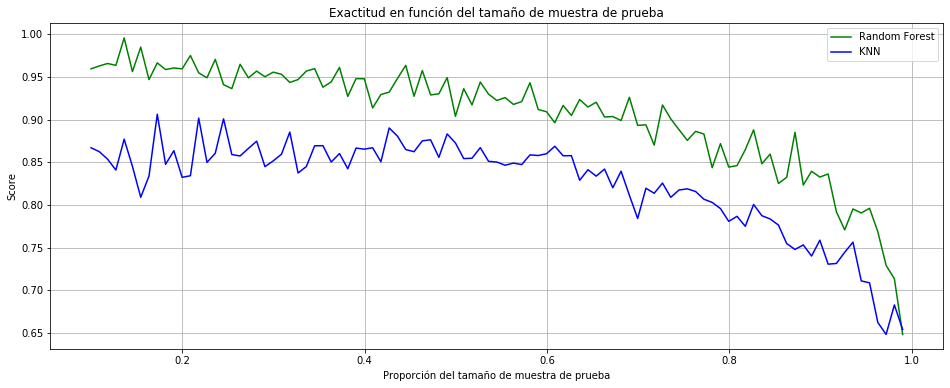

In [252]:
plt.figure(figsize=(16,6))
plt.plot(tam,test_scores, label="Random Forest", c="green")
plt.plot(tam, test_scores_KNN, label="KNN", c="blue")
plt.title("Exactitud en función del tamaño de muestra de prueba")
plt.xlabel("Proporción del tamaño de muestra de prueba")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

In [249]:
#Como podemos observar en general la predicción del modelo Random Forest
#es mejor. Se observa que conforme menos tamaño de muestra de entrenamiento
#tenemos una predicción más empobrecida; resaltando aún que el clasificador
#KNN está por debajo en todo momento.